In [1]:
import matplotlib.pyplot as plt

import pickle
import numpy as np

In [2]:
with open('sensitive_analysis_9v_100.pkl','r') as inputs:
    data= pickle.load(inputs)
with open('sensitive_analysis_base_renewal.pkl','r') as inputsbase:
    data_base = pickle.load(inputsbase)

In [16]:
data_base

[([0, 0.0, 0.016, 0.0, 20.596, 0.0, 467.399],
  array([ 0.83008905,  0.9817648 ,  0.84516012,  1.27475337,  1.0244052 ,
          1.03909195,  0.90698106,  1.12186177,  1.09019655,  1.18141355,
          1.13557453,  1.20591082,  1.16437795,  1.20458391,  0.92221481,
          1.02384782,  0.98053089,  1.02204561,  0.98350538,  1.03463193,
          0.99621408,  1.04990327,  1.01224988,  1.03877083,  1.0030059 ,
          1.05309382,  1.01533787,  1.0672604 ,  1.031859  ,  1.31708905,
          1.20937849,  0.93862589,  0.92277154,  0.95910073,  0.93632036,
          0.95944327,  0.93563764,  0.97310095,  0.94753735,  0.9559655 ,
          0.9310757 ,  0.9718174 ,  0.95279428,  0.96421669,  0.94645136,
          0.98412578,  0.88442933,  0.95401891,  0.92983628,  0.96817022,
          0.94927958,  0.96347038,  0.94350084,  0.98101486,  0.88842749,
          0.96121446,  0.94017485,  0.97685718,  0.8919154 ,  0.99293843,
          0.97050499,  1.08664179,  0.14972177]),
  9.491571057899

In [7]:
import datetime as dt
from tree import TreeModel
from bau import DLWBusinessAsUsual
from cost import DLWCost
from damage import DLWDamage
from utility import EZUtility
from optimization import GeneticAlgorithm, GradientSearch
import numpy as np
class matlabmode():
    def __init__(self):
        '''init the class with default settings:
        1. decision time is set to [0, 15, 45, 85, 185, 285, 385]
        2. cost is using default x60 = 0.543, x100 = 0.671 and euro to dollar exchange rate = 1.2
        3. In the back stop tech model, join price is set to 2000, max prive is set to 2500, phi_0 = 1.5, phi_1 = 0 and constant = 30460
        3. constant growth of consumption is set to 0.015, subinterval length is 5 and ghg levels are 450,650,1000.
        4. Draws of simulation  = 4000000
        5. Disaster model's set up is  peak_temperature=6.0, disaster_tail=18.0. 
        6. Damage is simulated by pindcyk method with time to hit the max temperature = 100
        7. In utility, the parameter rho from the DLW-paper is set to 1-1/0.9, alpha is set to -6 and beta is set to 0.995^5 '''

        t = TreeModel(decision_times=[0, 15, 45, 85, 185, 285, 385])
        bau_default_model = DLWBusinessAsUsual()
        bau_default_model.bau_emissions_setup(tree=t)
        c = DLWCost(t, bau_default_model.emit_level[0], g=92.08, a=3.413, join_price=2000.0, max_price=2500.0,
                        tech_const=1.5, tech_scale=0.0, cons_at_0=30460.0)
        df = DLWDamage(tree=t, bau=bau_default_model, cons_growth=0.015, ghg_levels=[450, 650, 1000], subinterval_len=5)    
        df.damage_simulation(draws=4000000, peak_temp=6.0, disaster_tail=18.0, tip_on=True, 
                                 temp_map=0, temp_dist_params=None, maxh=100.0)
        u = EZUtility(tree=t, damage=df, cost=c, period_len=5.0, eis=0.9, ra=7.0, time_pref=0.005)
        self.u = u

    def get_start_point(self):
        #use GA to get the start point for local optimizer
        ga_model = GeneticAlgorithm(pop_amount=150, num_generations=1, cx_prob=0.8, mut_prob=0.5, 
                              bound=1.5, num_feature=63, utility=self.u, print_progress=True) 
        final_pop, fitness = ga_model.run()
        sort_pop = final_pop[np.argsort(fitness)][::-1]
        return sort_pop

    def utility_grad(self,m):
        #use finite differenciation to gradient and utility
        m = np.array(m)
        gs_model = GradientSearch(var_nums=63, utility=self.u, accuracy=1e-8, 
                              iterations=1, print_progress=True)
        grad = gs_model.numerical_gradient(m)
        return self.u.utility(m),grad

    def grad(self,m):
        #use finite differenciation to gradient and utility
        m = np.array(m)
        gs_model = GradientSearch(var_nums=63, utility=self.u, accuracy=1e-8, 
                              iterations=1, print_progress=True)
        grad = gs_model.numerical_gradient(m)
        return grad

    def utility(self,m):
        # get utility from utlity class
        m = np.array(m)
        #result_array=np.array([])
        # if m.ndim ==1:
        return self.u.utility(m)
            
        # else:
        #     row= 10
        #     for row_index in range(row):
        #         result_array= np.append(result_array,self.u.utility(m[row_index,:]))
        #     return result_array

def get_start(y):
    return y.get_start_point()

def get_u_g(m,y):
    return y.utility_grad(m)

def get_u(m,y):
    return y.utility(m)

def get_g(m,y):
    return y.grad(m)

In [8]:
y = matlabmode()

Starting damage simulation..
Done!


In [9]:
x1 = y.get_start_point()

----------------Genetic Evolution Starting----------------
-- Generation 1 --
 Min 3.35298088992e-15 
 Max 8.69671823904 
 Avg 7.40813511098
 Std 2.11139523576 
 Population Size 150
 Best Individual:  [  2.32545812e-01   1.02546701e+00   3.34514633e-01   1.38908617e+00
   1.09278206e+00   7.25973125e-01   1.73954229e-01   9.71546048e-01
   2.14879049e-01   1.29332924e+00   8.61332659e-02   4.01065069e-01
   1.07733168e+00   1.44106712e+00   6.24649964e-01   1.29455098e+00
   7.77904778e-01   5.93550137e-01   7.23745556e-01   7.57567836e-01
   1.13555481e+00   1.13843975e+00   2.95739465e-01   7.79466584e-01
   4.29628398e-01   1.28528544e+00   1.22251968e+00   1.00634622e+00
   1.26347063e+00   7.55338893e-01   3.27449434e-01   7.95825640e-01
   1.64215439e-01   5.42924091e-01   6.17393032e-01   4.51517284e-02
   1.13740941e+00   6.96865287e-01   1.35456466e-01   1.75195071e-01
   1.06053450e+00   9.90789899e-01   8.83873607e-01   9.15247953e-01
   1.01071892e+00   5.97801938e-02   1.3

In [11]:
x1[:1]

array([[  2.32545812e-01,   1.02546701e+00,   3.34514633e-01,
          1.38908617e+00,   1.09278206e+00,   7.25973125e-01,
          1.73954229e-01,   9.71546048e-01,   2.14879049e-01,
          1.29332924e+00,   8.61332659e-02,   4.01065069e-01,
          1.07733168e+00,   1.44106712e+00,   6.24649964e-01,
          1.29455098e+00,   7.77904778e-01,   5.93550137e-01,
          7.23745556e-01,   7.57567836e-01,   1.13555481e+00,
          1.13843975e+00,   2.95739465e-01,   7.79466584e-01,
          4.29628398e-01,   1.28528544e+00,   1.22251968e+00,
          1.00634622e+00,   1.26347063e+00,   7.55338893e-01,
          3.27449434e-01,   7.95825640e-01,   1.64215439e-01,
          5.42924091e-01,   6.17393032e-01,   4.51517284e-02,
          1.13740941e+00,   6.96865287e-01,   1.35456466e-01,
          1.75195071e-01,   1.06053450e+00,   9.90789899e-01,
          8.83873607e-01,   9.15247953e-01,   1.01071892e+00,
          5.97801938e-02,   1.38923973e+00,   6.39609237e-01,
        

In [21]:
x = get_g(data_base[0][1],y)

In [24]:
m_t ='0.903879483936320	0.363429068455808	0.573327240626552	0.0850219497695642	0.127874993703247	0.151525814276405	0.986035915775205	0.441265495420156	0.253154179460103	0.259564792863577	0.208161562363009	0.970540857097490	0.238359398568151	0.499152902151700	0.103887581572938	0.658739874492949	0.324901334269585	0.451424347985208	0.710026998770444	0.456196085863435	0.684419923385944	0.332973836377714	0.586519259498864	0.465674496830032	0.0815914315352912	0.538194558630774	0.436857638848319	0.278769651601049	0.671906328164850	0.740574089171126	0.263478154559095	0.942635530215477	0.356542711325427	0.488581908426025	0.800536830135403	1.00022306144958	0.585262881612693	0.484230928649010	0.502892700949846	1.01978165009667	0.356470822280127	0.415975369598411	0.307999109033091	0.500391313498943	0.596831059714939	0.275277760971193	0.544947252465684	1.23307277447374	0.399846165964901	0.312025859552821	0.450329423966375	0.684139523296810	0.583741012653225	0.687064299034125	0.725676286975953	0.672343227494014	0.719600490885657	0.544693552923714	0.340558030615798	0.236754044020643	0.690846411134270	0.721410828755815	0.991257284346195'

In [31]:
list1=m_t.split('\t')

In [29]:
len(list1)

1

In [33]:
np.linalg.norm(list1)

4.6369644235393688

In [8]:
data_base[0][1]

array([ 0.83008905,  0.9817648 ,  0.84516012,  1.27475337,  1.0244052 ,
        1.03909195,  0.90698106,  1.12186177,  1.09019655,  1.18141355,
        1.13557453,  1.20591082,  1.16437795,  1.20458391,  0.92221481,
        1.02384782,  0.98053089,  1.02204561,  0.98350538,  1.03463193,
        0.99621408,  1.04990327,  1.01224988,  1.03877083,  1.0030059 ,
        1.05309382,  1.01533787,  1.0672604 ,  1.031859  ,  1.31708905,
        1.20937849,  0.93862589,  0.92277154,  0.95910073,  0.93632036,
        0.95944327,  0.93563764,  0.97310095,  0.94753735,  0.9559655 ,
        0.9310757 ,  0.9718174 ,  0.95279428,  0.96421669,  0.94645136,
        0.98412578,  0.88442933,  0.95401891,  0.92983628,  0.96817022,
        0.94927958,  0.96347038,  0.94350084,  0.98101486,  0.88842749,
        0.96121446,  0.94017485,  0.97685718,  0.8919154 ,  0.99293843,
        0.97050499,  1.08664179,  0.14972177])

In [4]:
def get_price_stat_ave(data,decision_times): #period average for each sample
    mitigation = []
    utility = []
    price = []
    a650 = []
    from tree import TreeModel 
    for i in range(len(data)): #load corresponding results
        mitigation.append(data[i][-3])
        utility.append(data[i][-2])
        price.append(data[i][-1])
        #a650.append(data[i][2])
    #print(np.mean(a650))
    
    t = TreeModel(decision_times)
    nodes_index = []
    for i in range(t.num_periods):
        nodes_index.append(t.get_nodes_in_period(i)) #get nodes for slicing
    price_stat_ave = np.zeros((len(data), t.num_periods))
    for i in range(len(data)):
        for j in range(t.num_periods):
            price_stat_ave[i,j] = np.average(data[i][-1][nodes_index[j][0]:nodes_index[j][1]+1])
    return price_stat_ave

def get_90_quantile(price_stat_ave):
    list0 = price_stat_ave[:,0]
    list1 = price_stat_ave[:,1]
    list2 = price_stat_ave[:,2]
    list3 = price_stat_ave[:,3]
    list4 = price_stat_ave[:,4]
    list5 = price_stat_ave[:,5]
    list_ = [list0,list1,list2,list3,list4,list5]
    fivepercent = int(len(list0)*0.05)
    for i in range(len(list_)):
        list_[i]=np.sort(list_[i])[fivepercent:-fivepercent] #take the 90% of the sorted results
    list_min = []
    list_max = []
    for i in list_:
        list_min.append(i[0])
        list_max.append(i[-1])   
    return list_min,list_max #take the lower and upper bounds for the test results

In [5]:
decision_times=[0, 15, 45, 85, 185, 285, 385]
price_stat_ave= get_price_stat_ave(data,decision_times)
price_stat_ave_base =get_price_stat_ave(data_base,decision_times)

list_min,list_max = get_90_quantile(price_stat_ave)
plt.figure()
plt.plot(decision_times[:-1],list_min, 'r--')
plt.plot(decision_times[:-1],list_max,'r--')
plt.plot(decision_times[:-1],price_stat_ave_base[0,:],'b')
plt.title('Sensitivity Analysis for Variable theta1000', size ='xx-large')
plt.ylabel('Price in $', size = 'x-large')
plt.xlabel('Period Index', size = 'x-large')

plt.savefig('sensitivity_analysis_theta1000')
#plt.xlim(decision_times)

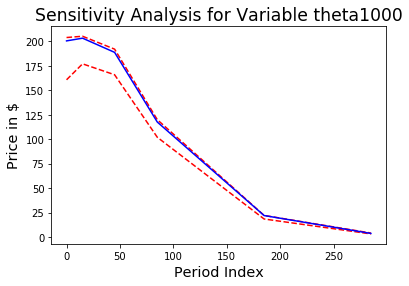

In [6]:
plt.show()